In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 12,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 172MB/s]


In [8]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7732 | F1: 0.3573
[Validate] Cardiomegaly AUC: 0.8754 | F1: 0.3426
[Validate] Consolidation AUC: 0.8119 | F1: 0.2693
[Validate] Edema AUC: 0.9022 | F1: 0.1471
[Validate] Effusion AUC: 0.8675 | F1: 0.5164
[Validate] Emphysema AUC: 0.9074 | F1: 0.3861
[Validate] Fibrosis AUC: 0.7860 | F1: 0.1410
[Validate] Hernia AUC: 0.8486 | F1: 0.0000
[Validate] Infiltration AUC: 0.6910 | F1: 0.3676
[Validate] Mass AUC: 0.7936 | F1: 0.2961
[Validate] Nodule AUC: 0.7667 | F1: 0.3097
[Validate] Pleural_Thickening AUC: 0.7670 | F1: 0.2096
[Validate] Pneumonia AUC: 0.7239 | F1: 0.1029
[Validate] Pneumothorax AUC: 0.8740 | F1: 0.4724
[Validate] Avg AUC: 0.8135, Avg F1: 0.2799
Training Loss: 0.0465
Validation Loss: 0.0424
Validation AUC: 0.8135
Validation F1: 0.2799
✓ NEW BEST MODEL! Saved at models/best_model_20250915-215129.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8049 | F1: 0.3886
[Validate] Cardiomegaly AUC: 0.8773 | F1: 0.3682
[Validate] Consolidation AUC: 0.8087 | F1: 0.2447
[Validate] Edema AUC: 0.9086 | F1: 0.1860
[Validate] Effusion AUC: 0.8753 | F1: 0.5303
[Validate] Emphysema AUC: 0.9099 | F1: 0.4630
[Validate] Fibrosis AUC: 0.7609 | F1: 0.1449
[Validate] Hernia AUC: 0.9239 | F1: 0.1579
[Validate] Infiltration AUC: 0.6935 | F1: 0.3829
[Validate] Mass AUC: 0.8121 | F1: 0.3309
[Validate] Nodule AUC: 0.7704 | F1: 0.3384
[Validate] Pleural_Thickening AUC: 0.7842 | F1: 0.2212
[Validate] Pneumonia AUC: 0.7479 | F1: 0.1198
[Validate] Pneumothorax AUC: 0.8842 | F1: 0.4912
[Validate] Avg AUC: 0.8258, Avg F1: 0.3120
Training Loss: 0.0441
Validation Loss: 0.0419
Validation AUC: 0.8258
Validation F1: 0.3120
✓ NEW BEST MODEL! Saved at models/best_model_20250915-221756.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
     if w.is_alive():  
        ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^
 
  File "/usr/lib/pytho

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8062 | F1: 0.3914
[Validate] Cardiomegaly AUC: 0.9075 | F1: 0.3871
[Validate] Consolidation AUC: 0.8172 | F1: 0.2731
[Validate] Edema AUC: 0.9048 | F1: 0.1947
[Validate] Effusion AUC: 0.8749 | F1: 0.5251
[Validate] Emphysema AUC: 0.9224 | F1: 0.4837
[Validate] Fibrosis AUC: 0.7973 | F1: 0.1587
[Validate] Hernia AUC: 0.9312 | F1: 0.2609
[Validate] Infiltration AUC: 0.6988 | F1: 0.3812
[Validate] Mass AUC: 0.8074 | F1: 0.3053
[Validate] Nodule AUC: 0.7892 | F1: 0.3368
[Validate] Pleural_Thickening AUC: 0.7811 | F1: 0.2391
[Validate] Pneumonia AUC: 0.7250 | F1: 0.1205
[Validate] Pneumothorax AUC: 0.8958 | F1: 0.5006
[Validate] Avg AUC: 0.8328, Avg F1: 0.3256
Training Loss: 0.0432
Validation Loss: 0.0410
Validation AUC: 0.8328
Validation F1: 0.3256
✓ NEW BEST MODEL! Saved at models/best_model_20250915-224336.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040><function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^  ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8118 | F1: 0.4095
[Validate] Cardiomegaly AUC: 0.9056 | F1: 0.4012
[Validate] Consolidation AUC: 0.8236 | F1: 0.2663
[Validate] Edema AUC: 0.9060 | F1: 0.1797
[Validate] Effusion AUC: 0.8784 | F1: 0.5284
[Validate] Emphysema AUC: 0.9265 | F1: 0.4602
[Validate] Fibrosis AUC: 0.8009 | F1: 0.1517
[Validate] Hernia AUC: 0.9412 | F1: 0.3810
[Validate] Infiltration AUC: 0.6896 | F1: 0.3920
[Validate] Mass AUC: 0.8173 | F1: 0.3143
[Validate] Nodule AUC: 0.7705 | F1: 0.3280
[Validate] Pleural_Thickening AUC: 0.7809 | F1: 0.2292
[Validate] Pneumonia AUC: 0.7318 | F1: 0.1077
[Validate] Pneumothorax AUC: 0.9050 | F1: 0.5052
[Validate] Avg AUC: 0.8349, Avg F1: 0.3325
Training Loss: 0.0426
Validation Loss: 0.0410
Validation AUC: 0.8349
Validation F1: 0.3325
✓ NEW BEST MODEL! Saved at models/best_model_20250915-230900.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8019 | F1: 0.3828
[Validate] Cardiomegaly AUC: 0.9053 | F1: 0.4000
[Validate] Consolidation AUC: 0.8282 | F1: 0.2669
[Validate] Edema AUC: 0.9045 | F1: 0.1767
[Validate] Effusion AUC: 0.8777 | F1: 0.5321
[Validate] Emphysema AUC: 0.9359 | F1: 0.5054
[Validate] Fibrosis AUC: 0.7999 | F1: 0.1517
[Validate] Hernia AUC: 0.9280 | F1: 0.4000
[Validate] Infiltration AUC: 0.7098 | F1: 0.3959
[Validate] Mass AUC: 0.8160 | F1: 0.3060
[Validate] Nodule AUC: 0.7729 | F1: 0.3322
[Validate] Pleural_Thickening AUC: 0.7917 | F1: 0.2455
[Validate] Pneumonia AUC: 0.7145 | F1: 0.1220
[Validate] Pneumothorax AUC: 0.8982 | F1: 0.5018
[Validate] Avg AUC: 0.8346, Avg F1: 0.3371
Training Loss: 0.0423
Validation Loss: 0.0411
Validation AUC: 0.8346
Validation F1: 0.3371
No improvement. Patience: 1/5

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8275 | F1: 0.4269
[Validate] Cardiomegaly AUC: 0.9156 | F1: 0.4238
[Validate] Consolidation AUC: 0.8223 | F1: 0.2657
[Validate] Edema AUC: 0.9036 | F1: 0.1923
[Validate] Effusion AUC: 0.8829 | F1: 0.5398
[Validate] Emphysema AUC: 0.9348 | F1: 0.5115
[Validate] Fibrosis AUC: 0.8182 | F1: 0.1591
[Validate] Hernia AUC: 0.9427 | F1: 0.4211
[Validate] Infiltration AUC: 0.7173 | F1: 0.4012
[Validate] Mass AUC: 0.8316 | F1: 0.3292
[Validate] Nodule AUC: 0.7862 | F1: 0.3532
[Validate] Pleural_Thickening AUC: 0.7977 | F1: 0.2570
[Validate] Pneumonia AUC: 0.7201 | F1: 0.0966
[Validate] Pneumothorax AUC: 0.9051 | F1: 0.5040
[Validate] Avg AUC: 0.8432, Avg F1: 0.3487
Training Loss: 0.0409
Validation Loss: 0.0399
Validation AUC: 0.8432
Validation F1: 0.3487
✓ NEW BEST MODEL! Saved at models/best_model_20250916-000144.pth

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8277 | F1: 0.4191
[Validate] Cardiomegaly AUC: 0.9168 | F1: 0.4048
[Validate] Consolidation AUC: 0.8218 | F1: 0.2630
[Validate] Edema AUC: 0.9080 | F1: 0.1830
[Validate] Effusion AUC: 0.8844 | F1: 0.5415
[Validate] Emphysema AUC: 0.9350 | F1: 0.5225
[Validate] Fibrosis AUC: 0.8157 | F1: 0.1711
[Validate] Hernia AUC: 0.9453 | F1: 0.4444
[Validate] Infiltration AUC: 0.7204 | F1: 0.4097
[Validate] Mass AUC: 0.8298 | F1: 0.3471
[Validate] Nodule AUC: 0.7905 | F1: 0.3502
[Validate] Pleural_Thickening AUC: 0.7963 | F1: 0.2483
[Validate] Pneumonia AUC: 0.7171 | F1: 0.0986
[Validate] Pneumothorax AUC: 0.9057 | F1: 0.5073
[Validate] Avg AUC: 0.8439, Avg F1: 0.3507
Training Loss: 0.0406
Validation Loss: 0.0400
Validation AUC: 0.8439
Validation F1: 0.3507
✓ NEW BEST MODEL! Saved at models/best_model_20250916-002849.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040><function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^ Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040>^^^
^^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datal

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8325 | F1: 0.4300
[Validate] Cardiomegaly AUC: 0.9151 | F1: 0.4211
[Validate] Consolidation AUC: 0.8279 | F1: 0.2669
[Validate] Edema AUC: 0.9071 | F1: 0.1925
[Validate] Effusion AUC: 0.8845 | F1: 0.5466
[Validate] Emphysema AUC: 0.9350 | F1: 0.5083
[Validate] Fibrosis AUC: 0.8222 | F1: 0.1589
[Validate] Hernia AUC: 0.9414 | F1: 0.4286
[Validate] Infiltration AUC: 0.7175 | F1: 0.4028
[Validate] Mass AUC: 0.8385 | F1: 0.3505
[Validate] Nodule AUC: 0.7919 | F1: 0.3501
[Validate] Pleural_Thickening AUC: 0.8032 | F1: 0.2570
[Validate] Pneumonia AUC: 0.7172 | F1: 0.1061
[Validate] Pneumothorax AUC: 0.9083 | F1: 0.5100
[Validate] Avg AUC: 0.8459, Avg F1: 0.3521
Training Loss: 0.0403
Validation Loss: 0.0398
Validation AUC: 0.8459
Validation F1: 0.3521
✓ NEW BEST MODEL! Saved at models/best_model_20250916-005517.pth

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8305 | F1: 0.4345
[Validate] Cardiomegaly AUC: 0.9166 | F1: 0.4184
[Validate] Consolidation AUC: 0.8246 | F1: 0.2670
[Validate] Edema AUC: 0.9055 | F1: 0.1824
[Validate] Effusion AUC: 0.8854 | F1: 0.5446
[Validate] Emphysema AUC: 0.9370 | F1: 0.5152
[Validate] Fibrosis AUC: 0.8184 | F1: 0.1806
[Validate] Hernia AUC: 0.9554 | F1: 0.4706
[Validate] Infiltration AUC: 0.7161 | F1: 0.4009
[Validate] Mass AUC: 0.8480 | F1: 0.3616
[Validate] Nodule AUC: 0.7914 | F1: 0.3529
[Validate] Pleural_Thickening AUC: 0.8007 | F1: 0.2563
[Validate] Pneumonia AUC: 0.7197 | F1: 0.0985
[Validate] Pneumothorax AUC: 0.9067 | F1: 0.5078
[Validate] Avg AUC: 0.8468, Avg F1: 0.3565
Training Loss: 0.0402
Validation Loss: 0.0397
Validation AUC: 0.8468
Validation F1: 0.3565
✓ NEW BEST MODEL! Saved at models/best_model_20250916-012235.pth

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8273 | F1: 0.4200
[Validate] Cardiomegaly AUC: 0.9179 | F1: 0.4317
[Validate] Consolidation AUC: 0.8199 | F1: 0.2597
[Validate] Edema AUC: 0.9031 | F1: 0.1760
[Validate] Effusion AUC: 0.8829 | F1: 0.5403
[Validate] Emphysema AUC: 0.9363 | F1: 0.5191
[Validate] Fibrosis AUC: 0.8214 | F1: 0.1768
[Validate] Hernia AUC: 0.9587 | F1: 0.5000
[Validate] Infiltration AUC: 0.7162 | F1: 0.4005
[Validate] Mass AUC: 0.8410 | F1: 0.3495
[Validate] Nodule AUC: 0.7913 | F1: 0.3505
[Validate] Pleural_Thickening AUC: 0.7998 | F1: 0.2536
[Validate] Pneumonia AUC: 0.7119 | F1: 0.1089
[Validate] Pneumothorax AUC: 0.9078 | F1: 0.5070
[Validate] Avg AUC: 0.8454, Avg F1: 0.3567
Training Loss: 0.0400
Validation Loss: 0.0399
Validation AUC: 0.8454
Validation F1: 0.3567
No improvement. Patience: 1/5

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8320 | F1: 0.4273
[Validate] Cardiomegaly AUC: 0.9138 | F1: 0.4214
[Validate] Consolidation AUC: 0.8211 | F1: 0.2672
[Validate] Edema AUC: 0.9024 | F1: 0.1818
[Validate] Effusion AUC: 0.8858 | F1: 0.5447
[Validate] Emphysema AUC: 0.9353 | F1: 0.5284
[Validate] Fibrosis AUC: 0.8235 | F1: 0.1869
[Validate] Hernia AUC: 0.9532 | F1: 0.5000
[Validate] Infiltration AUC: 0.7186 | F1: 0.4012
[Validate] Mass AUC: 0.8462 | F1: 0.3533
[Validate] Nodule AUC: 0.7911 | F1: 0.3584
[Validate] Pleural_Thickening AUC: 0.8015 | F1: 0.2624
[Validate] Pneumonia AUC: 0.7128 | F1: 0.0970
[Validate] Pneumothorax AUC: 0.9066 | F1: 0.5090
[Validate] Avg AUC: 0.8460, Avg F1: 0.3599
Training Loss: 0.0399
Validation Loss: 0.0397
Validation AUC: 0.8460
Validation F1: 0.3599
No improvement. Patience: 2/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8297 | F1: 0.4254
[Validate] Cardiomegaly AUC: 0.9155 | F1: 0.4207
[Validate] Consolidation AUC: 0.8214 | F1: 0.2704
[Validate] Edema AUC: 0.9041 | F1: 0.1887
[Validate] Effusion AUC: 0.8853 | F1: 0.5457
[Validate] Emphysema AUC: 0.9373 | F1: 0.5223
[Validate] Fibrosis AUC: 0.8221 | F1: 0.1845
[Validate] Hernia AUC: 0.9540 | F1: 0.5000
[Validate] Infiltration AUC: 0.7188 | F1: 0.4020
[Validate] Mass AUC: 0.8441 | F1: 0.3523
[Validate] Nodule AUC: 0.7906 | F1: 0.3552
[Validate] Pleural_Thickening AUC: 0.7988 | F1: 0.2612
[Validate] Pneumonia AUC: 0.7106 | F1: 0.1029
[Validate] Pneumothorax AUC: 0.9064 | F1: 0.5052
[Validate] Avg AUC: 0.8456, Avg F1: 0.3597
Training Loss: 0.0397
Validation Loss: 0.0396
Validation AUC: 0.8456
Validation F1: 0.3597
No improvement. Patience: 3/5

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040><function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040>
self._shutdown_workers()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

         Exception ignored in:  Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040> 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7e35e9f74040>^^Traceback (most recent 

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8283 | F1: 0.4253
[Validate] Cardiomegaly AUC: 0.9158 | F1: 0.4236
[Validate] Consolidation AUC: 0.8230 | F1: 0.2711
[Validate] Edema AUC: 0.9046 | F1: 0.1760
[Validate] Effusion AUC: 0.8852 | F1: 0.5438
[Validate] Emphysema AUC: 0.9361 | F1: 0.5159
[Validate] Fibrosis AUC: 0.8262 | F1: 0.1893
[Validate] Hernia AUC: 0.9569 | F1: 0.5000
[Validate] Infiltration AUC: 0.7191 | F1: 0.4042
[Validate] Mass AUC: 0.8444 | F1: 0.3612
[Validate] Nodule AUC: 0.7898 | F1: 0.3528
[Validate] Pleural_Thickening AUC: 0.7993 | F1: 0.2565
[Validate] Pneumonia AUC: 0.7090 | F1: 0.0966
[Validate] Pneumothorax AUC: 0.9067 | F1: 0.5087
[Validate] Avg AUC: 0.8460, Avg F1: 0.3589
Training Loss: 0.0397
Validation Loss: 0.0397
Validation AUC: 0.8460
Validation F1: 0.3589
No improvement. Patience: 4/5

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8300 | F1: 0.4277
[Validate] Cardiomegaly AUC: 0.9161 | F1: 0.4338
[Validate] Consolidation AUC: 0.8222 | F1: 0.2657
[Validate] Edema AUC: 0.9045 | F1: 0.1858
[Validate] Effusion AUC: 0.8850 | F1: 0.5434
[Validate] Emphysema AUC: 0.9348 | F1: 0.5099
[Validate] Fibrosis AUC: 0.8226 | F1: 0.1877
[Validate] Hernia AUC: 0.9487 | F1: 0.5000
[Validate] Infiltration AUC: 0.7189 | F1: 0.4052
[Validate] Mass AUC: 0.8438 | F1: 0.3561
[Validate] Nodule AUC: 0.7893 | F1: 0.3546
[Validate] Pleural_Thickening AUC: 0.7988 | F1: 0.2619
[Validate] Pneumonia AUC: 0.7128 | F1: 0.1089
[Validate] Pneumothorax AUC: 0.9060 | F1: 0.5086
[Validate] Avg AUC: 0.8453, Avg F1: 0.3607
Training Loss: 0.0397
Validation Loss: 0.0398
Validation AUC: 0.8453
Validation F1: 0.3607
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


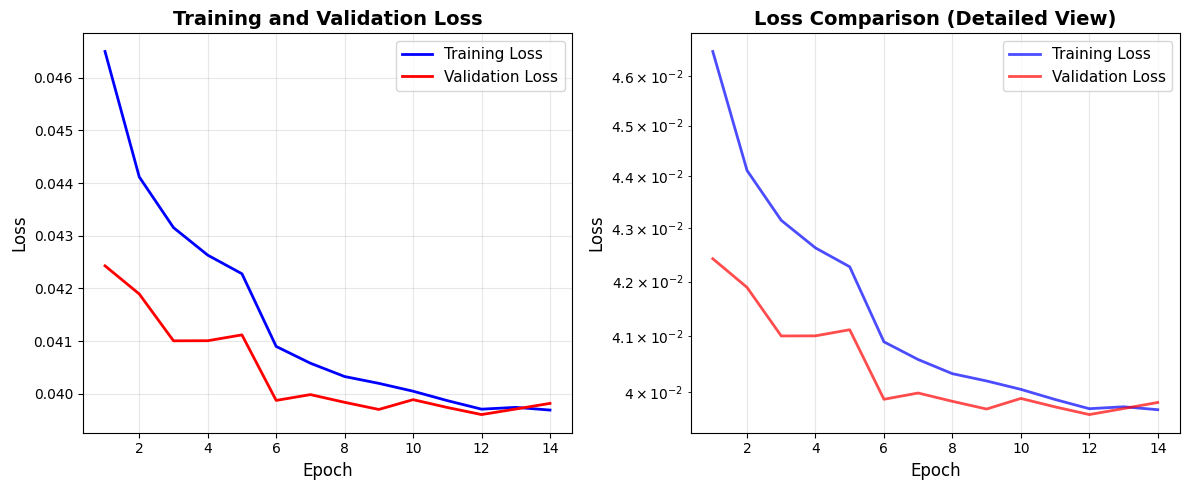


===== TRAINING SUMMARY =====
Final Training Loss: 0.0397
Final Validation Loss: 0.0398
Best Validation AUC: 0.8468
Total Epochs Trained: 14
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8047 | F1: 0.4034
[Test] Cardiomegaly AUC: 0.9320 | F1: 0.4808
[Test] Consolidation AUC: 0.7928 | F1: 0.2402
[Test] Edema AUC: 0.8841 | F1: 0.2694
[Test] Effusion AUC: 0.9010 | F1: 0.6125
[Test] Emphysema AUC: 0.9640 | F1: 0.5548
[Test] Fibrosis AUC: 0.8263 | F1: 0.1353
[Test] Hernia AUC: 0.9902 | F1: 0.6667
[Test] Infiltration AUC: 0.6975 | F1: 0.4048
[Test] Mass AUC: 0.9027 | F1: 0.4722
[Test] Nodule AUC: 0.7666 | F1: 0.2881
[Test] Pleural_Thickening AUC: 0.8019 | F1: 0.2446
[Test] Pneumonia AUC: 0.6726 | F1: 0.0684
[Test] Pneumothorax AUC: 0.8831 | F1: 0.3284
[Test] Avg AUC: 0.8443, Avg F1: 0.3693


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0420
Avg AUROC : 0.8443
Avg F1    : 0.3693

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8047     0.4034     0.3676    
Cardiomegaly         0.9320     0.4808     0.3754    
Consolidation        0.7928     0.2402     0.3269    
Edema                0.8841     0.2694     0.3251    
Effusion             0.9010     0.6125     0.4372    
Emphysema            0.9640     0.5548     0.3047    
Fibrosis             0.8263     0.1353     0.2885    
Hernia               0.9902     0.6667     0.5126    
Infiltration         0.6975     0.4048     0.3722    
Mass                 0.9027     0.4722     0.3898    
Nodule               0.7666     0.2881     0.3286    
Pleural_Thickening   0.8019     0.2446     0.2937    
Pneumonia            0.6726     0.0684     0.2684    
Pneumothorax         0.8831     0.3284     0.3383    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

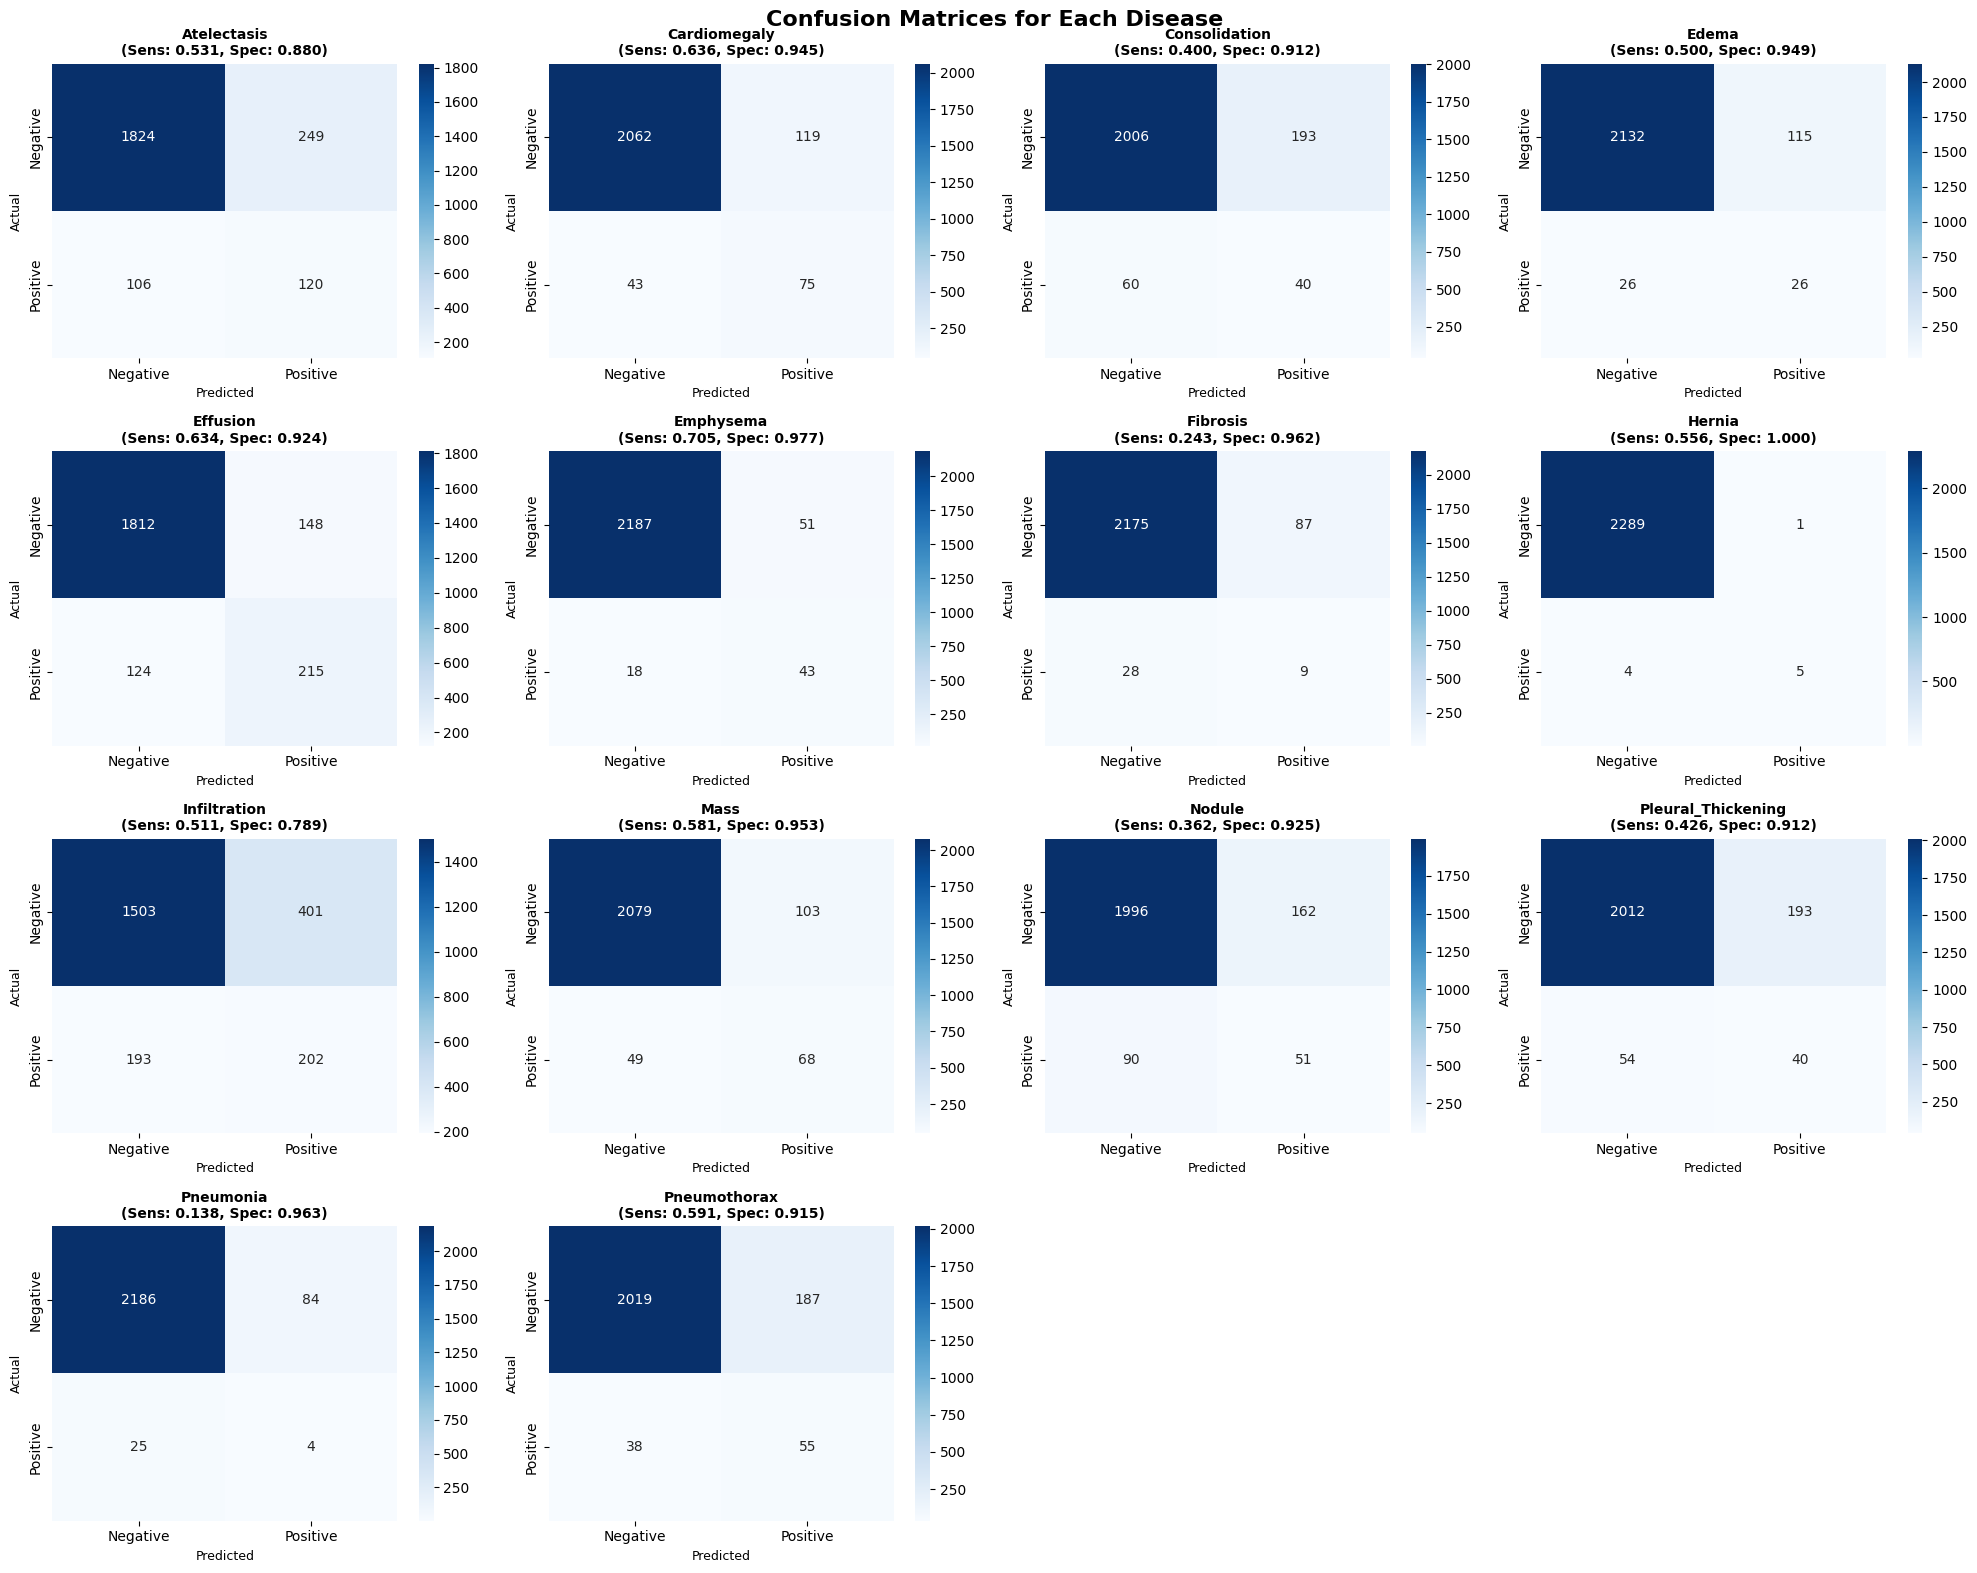

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          120    1824   249    106    0.531    0.880    0.325    0.945   
Cardiomegaly         75     2062   119    43     0.636    0.945    0.387    0.980   
Consolidation        40     2006   193    60     0.400    0.912    0.172    0.971   
Edema                26     2132   115    26     0.500    0.949    0.184    0.988   
Effusion             215    1812   148    124    0.634    0.924    0.592    0.936   
Emphysema            43     2187   51     18     0.705    0.977    0.457    0.992   
Fibrosis             9      2175   87     28     0.243    0.962    0.094    0.987   
Hernia               5      2289   1      4      0.556    1.000    0.833    0.998   
Infiltration         202    1503   401    193    0.511    0.789    0.335    0.886   
Ma